
# SVD
### Ejemplo compresión de una imagen
Vamos a empezar con un ejemplo simple. SVD puede ser usado en el contexto de imágenes para comprimir fotos. Si en lugar de guardar la foto entera (Matriz M de la clase), uno guardase una representación reducida de esta matriz (B) y la manera de pasar de un espacio a otro (V*), entonces un se podría ahorrar mucho espacio en el guardado de la foto. Este mismo proceso se utiliza a veces en imágenes y señales para reducir el ruido de las mismas (proceso llamdo denoising)

E formalismo de SVD nos asegura que dado el rango que eligamos (r), la foto que podamos reconstruir a partir de B y V* (M moño) será la "mas parecida" posible a la foto original (M)

Primero cargamos la foto. Si no la tienen, deberan bajarse la libreria PIL para hacer este proceso mas fácil

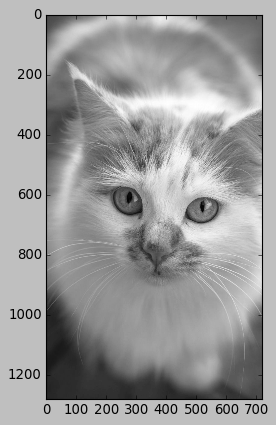

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('classic')
img = Image.open('gato.jpeg')
# convert image to grayscale
imggray = img.convert('LA')
# convert to numpy array
imgmat = np.array(list(imggray.getdata(band=0)), float)
# Reshape according to orginal image dimensions
imgmat.shape = (imggray.size[1], imggray.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(imgmat, cmap='gray')
plt.show()

In [2]:
imgmat.shape

(1280, 720)

Vamos a usar la versión clásica del algoritmo de SVD que viene en numpy (noten que importante que es, que viene por default en numpy, ya que se usa para muchas más cosas).

In [3]:
U, D, V = np.linalg.svd(imgmat)

Inspeccionemos la dimensión de los elementos:

In [4]:
imgmat.shape

(1280, 720)

In [5]:
U.shape

(1280, 1280)

In [6]:
D.shape

(720,)

In [7]:
V.shape

(720, 720)

Así como está, si multiplicamos adecuadamente estos tres elementos, recuperariamos la foto original. Veamos que si tomamos los 720 valores singulares tendremos la imagen original nuevamente:

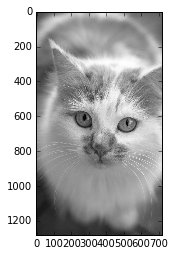

In [8]:
reconstimg = np.matrix(U[:, :720]) * np.diag(D[:720]) * np.matrix(V[:720, :])
plt.imshow(reconstimg, cmap='gray')
plt.show()

El objetivo pasa por tomar únicamente los valores singulares más altos. Por una cuestión de comodidad, los valores en D (notar que representa una matriz diagonal pero viene en forma de vector!) ya están ordenados de menor a mayor, siendo los primeros los de mayor valor. Ahora sí, vamos a probar tomando menos valores singulares, empecemos por sólo 2.

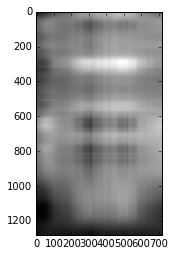

In [9]:
reconstimg = np.matrix(U[:, :2]) * np.diag(D[:2]) * np.matrix(V[:2, :])
plt.imshow(reconstimg, cmap='gray')
plt.show()

No es muy sorprendente el resultado, pero ya se puede al menos ver que hay un objeto en el centro de la imagen, para tener tan poca información (sólo los dos vectores propios asociados a los valores propios y los valores propios) no está tan mal. Ahora sí, barramos una cantidad más razonable de valores singulares, y observemos los resultados.

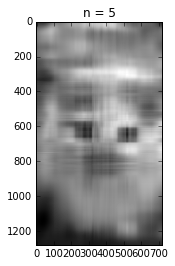

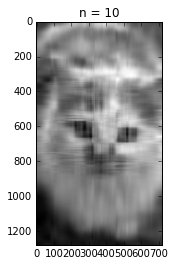

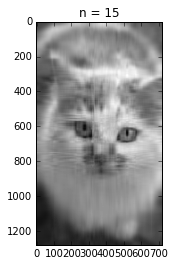

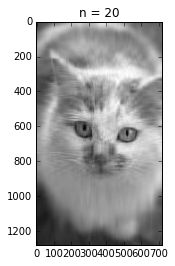

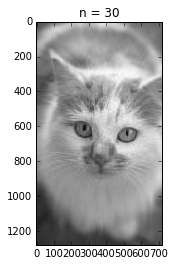

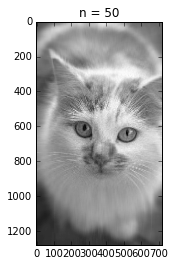

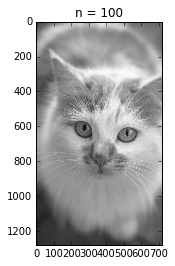

In [10]:
for i in [5, 10, 15, 20, 30, 50,100]:
    reconstimg = np.matrix(U[:, :i]) * np.diag(D[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

### Ejemplo con muchas imágenes
Vamos a trabajar ahora con una serie de imágenes de caras de personas famosas. Nuestro objetivo será encontrar un número r de "caras base" (o "eigenfaces"). Estas son las mejores caras que, al ser combinadas de alguna manera en particular, pueden generar de vuelta todas las caras de nuestro dataset.

In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dir_data_caras ='lfw1000'
# Vemos cuantos archivos hay en la carpeta
print(len(os.listdir(dir_data_caras)))

972


Buscamos los nombres de todos los archivos en la carpeta donde tenemos el dataset:

In [12]:
lista_data_caras = os.listdir(dir_data_caras)
lista_data_caras[:10]

['Kent_Rominger_0002.pgm',
 'Sophia_Loren_0003.pgm',
 'LeAnn_Rimes_0002.pgm',
 'Francisco_Flores_0003.pgm',
 'Simon_Chalk_0001.pgm',
 'Ariel_Sharon_0060.pgm',
 'George_W_Bush_0213.pgm',
 'Bill_McBride_0004.pgm',
 'Martina_McBride_0005.pgm',
 'Keith_Lowen_0001.pgm']

Definimos una función para leer este tipo de archivos:

In [13]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

Para graficar las imágenes las debemos leer con la función que creamos y reproducirla con imshow de matplotlib. Notemos que cada imagen son 64 x 64 pixeles, en escala de grises.

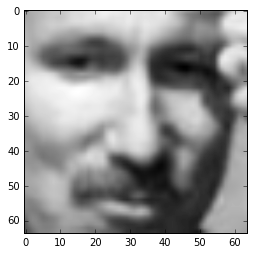

(64, 64)

In [14]:
image = read_pgm(dir_data_caras+'/'+lista_data_caras[0], byteorder='<')
plt.imshow(image, plt.cm.gray)
plt.show()
image.shape

Ahora vamos a armar una lista vacia y agregarle todas las matrices de las imágenes dentro.

In [15]:
lista_matrices_imagenes = []
# Notar que recorremos todos los archivos de la carpeta y los leemos uno por uno.
for nombre in lista_data_caras:
    image = read_pgm(dir_data_caras+'/'+nombre, byteorder='<')
    lista_matrices_imagenes.append(image)
    #print(nombre)
    if image.shape != (64,64):
        print('La imagen no tiene 64x64')

Llevamos cada imagen a un vector, y armamos una matriz donde el número de filas es la cantidad de imágenes y las columnas son los 64x64 pixeles de cada imagen.

In [16]:
m = len(lista_matrices_imagenes)
d = image.shape[0] * image.shape[1]
X = np.reshape(lista_matrices_imagenes, (m, d))

Para volver a pasar de fila de la matrix X a imagen solo debemos hacer el proceso inverso al reshape anterior.

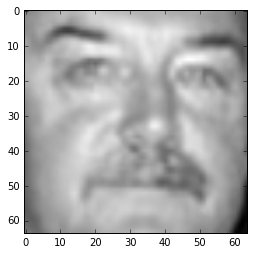

In [17]:
# To get back to an image, just reshape it again
plt.imshow((np.reshape(X[int(len(X)/2), :], (image.shape[0], image.shape[1]))), plt.cm.gray)
#plt.imshow((np.reshape(X[50, :], (image.shape[0], image.shape[1]))), plt.cm.gray)

Ahora si, aplicamos el algoritmo de SVD a toda esta matriz. Notemos que se lo apicamos a todas las imagenes juntas al mismo tiempo. Esto es diferente a lo que hicimos en el ejercicio anterior, buscamos "caras base" que representen de la mejor manera posible en nuestra población de caras.

In [18]:
U, D, V = np.linalg.svd(X, full_matrices=False)

In [19]:
# Chequeamos dimensiones
print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", D.shape)
print("VT:", V.shape)

X: (972, 4096)
U: (972, 972)
Sigma: (972,)
VT: (972, 4096)


Ahora reconstrimosla matrix X con solo 20 valores principales

In [20]:
numero = 20
new_X = np.matrix(U[:, :numero]) * np.diag(D[:numero]) * np.matrix(V[:numero, :])

Si volvemos a ver la cara anterior, vemos que ya podemos distinguirla, pero la resolución no es la optima. Prueben modificar el número de valroes princpales hasta encontrar uno que les parezca adecuado.

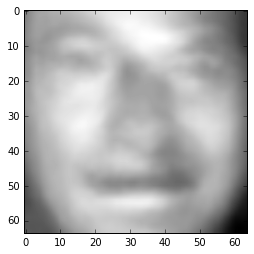

In [21]:
plt.imshow((np.reshape(new_X[int(len(new_X)/2), :], (image.shape[0], image.shape[1]))), plt.cm.gray)
#plt.imshow((np.reshape(new_X[50, :], (image.shape[0], image.shape[1]))), plt.cm.gray)

Ahora si, podemos explorar cuáles son las "caras base". Recordemos que nuestro "diccionario" para volver del espacio de la matriz B al espacio de la matriz original M es la matriz de vectores singulares por derecha V. Veamos que V tiene la forma (número de instancias x cantidad de píxeles):

In [22]:
V.shape

(972, 4096)

Las filas de V son entonces los vectores singulares por derecha, ordenados por orden de relevancia. V[0] es el que está asociado al valor singular más alto, V[1] al segundo, y así sucesivamente. Sumando de diferentes maneras los primeros r (por ejemplo, como vimos, los primeros 20), uno puede recuperar las imágenes originales. La información de cómo se deben sumar está en la matriz U.

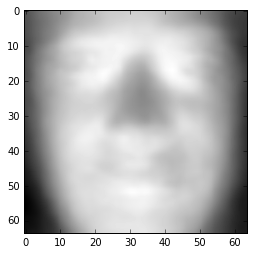

In [23]:
plt.imshow((np.reshape(V[2], (image.shape[0], image.shape[1]))), plt.cm.gray)

Este notebook es demostrativo, pero les sugerimos fuertemente probar diferentes valores y modificarlo.